# ChampSim analysis: pointer chasing vs streaming

This notebook parses metrics reports under `analysis/metrics/report_<n>.md` and plots array vs list results across sizes.

It produces grouped bar charts per metric and speedup tables for each N.


## Imports and paths

The plots are written to `results/plots/` (ignored by git).


In [28]:
from pathlib import Path
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

ROOT = Path('..').resolve()
REPORTS_DIR = ROOT / 'analysis' / 'metrics'
PLOTS_DIR = ROOT / 'results' / 'plots'
PLOTS_DIR.mkdir(parents=True, exist_ok=True)

sns.set_theme(style='whitegrid')

print('REPORTS_DIR:', REPORTS_DIR)
print('PLOTS_DIR:', PLOTS_DIR)


REPORTS_DIR: /home/mauer/pointer-chasing-vs-streaming/analysis/metrics
PLOTS_DIR: /home/mauer/pointer-chasing-vs-streaming/results/plots


## Parse `report_<n>.md` files into dataframes

Each report includes a heap/stack metrics table and a heap/stack wall-clock table.


In [29]:
REPORT_RE = re.compile(r'report_(?P<n>\d+)\.md$')


def parse_row(line: str) -> list[str]:
    return [part.strip() for part in line.strip().strip('|').split('|')]


def parse_numeric(value: str):
    if value is None:
        return np.nan
    v = value.strip()
    if v == '':
        return np.nan
    if v.endswith('%'):
        v = v[:-1]
    v = v.replace(',', '')
    try:
        return float(v)
    except ValueError:
        return value


def parse_table(section: str) -> list[dict]:
    lines = [line.strip() for line in section.splitlines() if line.strip()]
    if not lines:
        return []

    header_idx = None
    for i, line in enumerate(lines[:-1]):
        if line.startswith('|') and lines[i + 1].startswith('|---'):
            header_idx = i
            break
    if header_idx is None:
        return []

    header = parse_row(lines[header_idx])
    rows = []
    for line in lines[header_idx + 2:]:
        if not line.startswith('|'):
            break
        values = parse_row(line)
        if len(values) != len(header):
            continue
        rows.append(dict(zip(header, values)))
    return rows


def section_text(text: str, heading: str) -> str:
    pattern = re.compile(rf'^### {re.escape(heading)}\n(.*?)(?=^### |\Z)', re.M | re.S)
    match = pattern.search(text)
    return match.group(1).strip() if match else ''


def normalize_columns(columns: list[str]) -> dict:
    rename = {}
    for col in columns:
        c = col.strip().lower()
        c = c.replace('(', '').replace(')', '')
        c = c.replace(' ', '_').replace('-', '_')
        rename[col] = c
    return rename


def format_n(n: int) -> str:
    if n >= 1_000_000:
        return f'{n // 1_000_000}M'
    if n >= 1_000:
        return f'{n // 1_000}k'
    return str(n)


def parse_report(path: Path) -> tuple[pd.DataFrame, pd.DataFrame]:
    match = REPORT_RE.match(path.name)
    if not match:
        return pd.DataFrame(), pd.DataFrame()
    n = int(match.group('n'))
    text = path.read_text()

    metrics_rows = []
    runtime_rows = []

    for storage in ['Heap', 'Stack']:
        metrics_section = section_text(text, storage)
        if metrics_section and 'No data found' not in metrics_section:
            table_rows = parse_table(metrics_section)
            for row in table_rows:
                row['storage'] = storage.lower()
                row['n'] = n
                metrics_rows.append(row)

        runtime_section = section_text(text, f'{storage} wall-clock')
        if runtime_section and 'No data found' not in runtime_section:
            table_rows = parse_table(runtime_section)
            for row in table_rows:
                row['storage'] = storage.lower()
                row['n'] = n
                runtime_rows.append(row)

    metrics_df = pd.DataFrame(metrics_rows)
    runtime_df = pd.DataFrame(runtime_rows)

    if not metrics_df.empty:
        metrics_df = metrics_df.rename(columns=normalize_columns(metrics_df.columns))
        metrics_df['n'] = metrics_df['n'].astype(int)

    if not runtime_df.empty:
        runtime_df = runtime_df.rename(columns=normalize_columns(runtime_df.columns))
        runtime_df['n'] = runtime_df['n'].astype(int)

    return metrics_df, runtime_df


metric_frames = []
runtime_frames = []
for path in sorted(REPORTS_DIR.glob('report_*.md')):
    metrics_df, runtime_df = parse_report(path)
    if not metrics_df.empty:
        metric_frames.append(metrics_df)
    if not runtime_df.empty:
        runtime_frames.append(runtime_df)

metrics = pd.concat(metric_frames, ignore_index=True) if metric_frames else pd.DataFrame()
runtime = pd.concat(runtime_frames, ignore_index=True) if runtime_frames else pd.DataFrame()

if metrics.empty and runtime.empty:
    raise RuntimeError('No report_<n>.md files found in analysis/metrics')

for df in [metrics, runtime]:
    if df.empty:
        continue
    for col in df.columns:
        if col in {'workload', 'storage', 'n'}:
            continue
        df[col] = df[col].map(parse_numeric)
    df['n'] = df['n'].astype(int)

if not metrics.empty:
    metrics['n_label'] = metrics['n'].map(format_n)
if not runtime.empty:
    runtime['n_label'] = runtime['n'].map(format_n)

metrics.head(), runtime.head()


(          workload    ipc  l1d_load_hit_rate  l1d_load_miss_rate  \
 0        array_add  2.773              56.27               43.73   
 1         list_add  0.553              77.15               22.85   
 2  array_add_stack  2.647              68.21               31.79   
 3   list_add_stack  1.208              86.21               13.79   
 4        array_add  0.636              12.59               87.41   
 
    l1d_load_accesses  llc_load_hit_rate  llc_load_miss_rate  \
 0           109692.0              96.80                3.20   
 1           121475.0              87.54               12.46   
 2           686723.0              73.19               26.81   
 3           846183.0              87.76               12.24   
 4           623549.0               1.30               98.70   
 
    l1d_load_mshr_merges  l1d_load_mshr_rate storage        n n_label  
 0               41107.0             37.4749    heap   100000    100k  
 1                1586.0              1.3056    heap  

## Helper utilities for plots and speedups

Speedup (array/list) is printed on each plot. Higher-is-better metrics use `array / list`; lower-is-better metrics use `list / array`.


In [30]:
def compute_speedup(df: pd.DataFrame, value_col: str, higher_is_better: bool) -> pd.DataFrame:
    rows = []
    for n, g in df.groupby('n'):
        if not {'array_add', 'list_add'}.issubset(set(g['workload'])):
            continue
        array_val = g[g['workload'] == 'array_add'][value_col].iloc[0]
        list_val = g[g['workload'] == 'list_add'][value_col].iloc[0]
        if pd.isna(array_val) or pd.isna(list_val) or array_val == 0 or list_val == 0:
            speedup = np.nan
        else:
            speedup = (array_val / list_val) if higher_is_better else (list_val / array_val)
        rows.append({
            'n': n,
            'n_label': format_n(n),
            'speedup': speedup,
        })
    return pd.DataFrame(rows)


def format_speedups(speedups: pd.DataFrame) -> str:
    if speedups.empty:
        return ''
    lines = []
    for _, row in speedups.sort_values('n').iterrows():
        value = 'n/a' if pd.isna(row['speedup']) else f"{row['speedup']:.2f}x"
        lines.append(f"{row['n_label']}: {value}")
    return "Speedup (array/list):\n" + "\n".join(lines)


def plot_metric(df: pd.DataFrame, value_col: str, title: str, ylabel: str, out_name: str, higher_is_better: bool):
    data = df[(df['storage'] == 'heap') & df['workload'].isin(['array_add', 'list_add'])]
    if data.empty:
        print(f'No data for {value_col}')
        return None, pd.DataFrame()

    data = data.sort_values(['workload', 'n'])

    fig, ax = plt.subplots(1, 1, figsize=(5.5, 4), sharey=False)
    sns.barplot(data=data, x='workload', y=value_col, hue='n_label', ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Workload')
    ax.set_ylabel(ylabel)
    ax.legend(title='N', loc='upper right')

    speedups = compute_speedup(data, value_col, higher_is_better=higher_is_better)
    text = format_speedups(speedups)
    if text:
        ax.text(0.02, 0.98, text, transform=ax.transAxes, va='top', ha='left',
                fontsize=9, bbox=dict(boxstyle='round', facecolor='white', alpha=0.75, edgecolor='0.3'))

    plt.tight_layout()
    out = PLOTS_DIR / out_name
    fig.savefig(out, dpi=160)
    return out, speedups


## Runtime (ms)

Grouped by workload (array vs list) with N as the column groups.


(PosixPath('/home/mauer/pointer-chasing-vs-streaming/results/plots/runtime_by_n.png'),
          n n_label   speedup
 0   100000    100k  2.581395
 1  1000000      1M  3.798450)

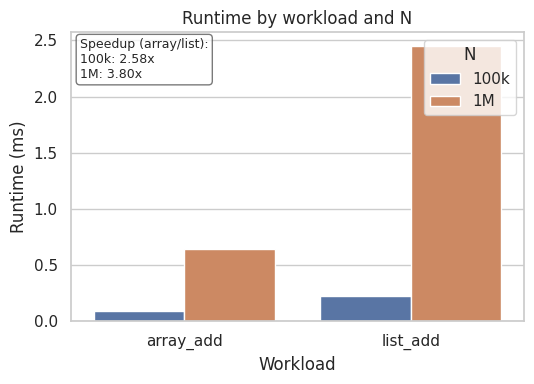

In [31]:
runtime_out, runtime_speedup = plot_metric(
    runtime,
    'runtime_ms',
    'Runtime by workload and N',
    'Runtime (ms)',
    'runtime_by_n.png',
    higher_is_better=False,
)
runtime_out, runtime_speedup


## IPC


(PosixPath('/home/mauer/pointer-chasing-vs-streaming/results/plots/ipc_by_n.png'),
          n n_label   speedup
 0   100000    100k  5.014467
 1  1000000      1M  3.553073)

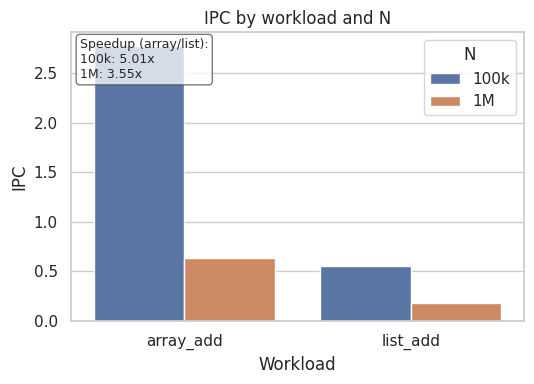

In [32]:
ipc_out, ipc_speedup = plot_metric(
    metrics,
    'ipc',
    'IPC by workload and N',
    'IPC',
    'ipc_by_n.png',
    higher_is_better=True,
)
ipc_out, ipc_speedup


## L1D load MSHR merge rate


(PosixPath('/home/mauer/pointer-chasing-vs-streaming/results/plots/l1d_mshr_merge_rate_by_n.png'),
          n n_label   speedup
 0   100000    100k  0.034839
 1  1000000      1M  0.000001)

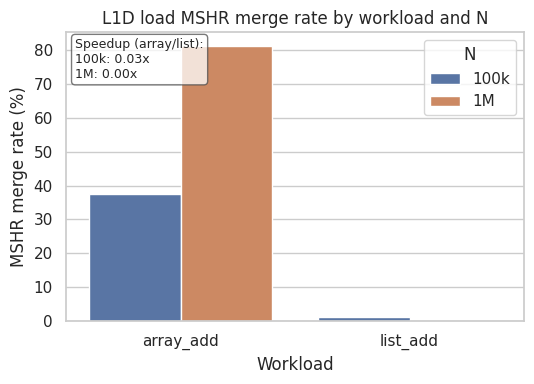

In [33]:
mshr_out, mshr_speedup = plot_metric(
    metrics,
    'l1d_load_mshr_rate',
    'L1D load MSHR merge rate by workload and N',
    'MSHR merge rate (%)',
    'l1d_mshr_merge_rate_by_n.png',
    higher_is_better=False,
)
mshr_out, mshr_speedup


## Cache miss rates

L1D and LLC load miss rates are plotted separately.


(PosixPath('/home/mauer/pointer-chasing-vs-streaming/results/plots/l1d_miss_rate_by_n.png'),
 PosixPath('/home/mauer/pointer-chasing-vs-streaming/results/plots/llc_miss_rate_by_n.png'),
          n n_label   speedup
 0   100000    100k  0.522525
 1  1000000      1M  0.286008,
          n n_label   speedup
 0   100000    100k  3.893750
 1  1000000      1M  1.013171)

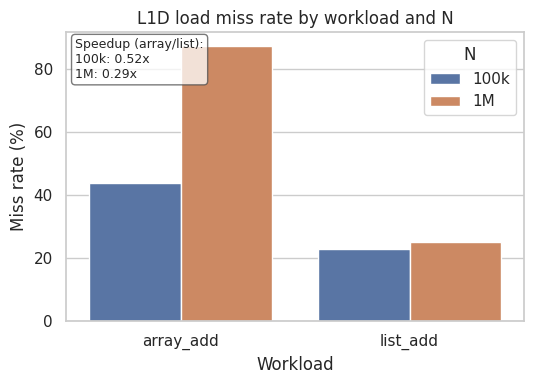

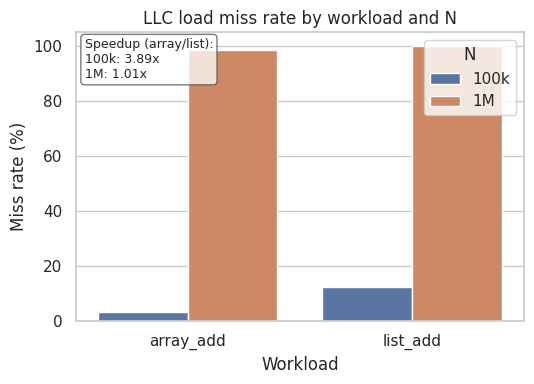

In [34]:
l1d_miss_out, l1d_miss_speedup = plot_metric(
    metrics,
    'l1d_load_miss_rate',
    'L1D load miss rate by workload and N',
    'Miss rate (%)',
    'l1d_miss_rate_by_n.png',
    higher_is_better=False,
)
llc_miss_out, llc_miss_speedup = plot_metric(
    metrics,
    'llc_load_miss_rate',
    'LLC load miss rate by workload and N',
    'Miss rate (%)',
    'llc_miss_rate_by_n.png',
    higher_is_better=False,
)

l1d_miss_out, llc_miss_out, l1d_miss_speedup, llc_miss_speedup
